# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:180%; font-family:Arial, sans-serif; background-color:#560c10; color:#DCD2C9; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> Movie Magic: Data-Driven Recommendations </b></div>

![movie](https://i.postimg.cc/qMKfD6sK/flat-design-movie-theater-background-23-2150998492.jpg)

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 1. Import Necessary Libraries </b></div>

In [1]:
# Import libraries
import pandas as pd              
import numpy as np                   
import matplotlib.pyplot as plt      
import seaborn as sns                
from matplotlib.colors import LinearSegmentedColormap 
from sklearn.model_selection import train_test_split  
from tensorflow.keras import layers, models  
import ast                            
import warnings                       

# Set the style and color palette for Seaborn visualizations
palette = ['#f28a30', '#3b94d9', '#e0c72c', '#6a4d8e', '#e63946', '#2a9d8f', '#264653']
sns.set_theme(context='notebook', palette=palette, style='white')

# Suppress specific FutureWarning messages to clean up output
warnings.simplefilter(action='ignore', category=FutureWarning)

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 2. Data Cleaning and Data Merging </b></div>

- **Step 1: Reading Data.** Let's begin by reading in two CSV files: one containing movie metadata (movies_metadata.csv) and another with user ratings (ratings_small.csv). These files form the foundation of our recommendation system.
- **Step 2: Cleaning the Movies Data.** The id column in the movies dataset needs to be numeric for the merging process later. We'll convert this column to a numeric format, handling any errors by replacing invalid entries with NaN values. Rows with missing values in the id column are then dropped to ensure a clean dataset.
- **Step 3: Merging Datasets.** To combine user ratings with movie metadata, we merge the ratings dataset with the cleaned movies dataset using the movieId and id columns. This produces a unified dataset containing both user rating information and movie details.

In [ ]:
# Define file paths for the datasets
movies_metadata_path = 'movies_metadata.csv'
ratings_small_path = 'ratings_small.csv'

# Read the CSV files containing movie metadata and user ratings
movies = pd.read_csv(movies_metadata_path, low_memory=False)
ratings = pd.read_csv(ratings_small_path)

# Clean up the 'id' column in the movies dataframe
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')  # 'coerce' turns invalid parsing into NaN

# Drop rows where 'id' is NaN (i.e., rows with invalid IDs)
movies.dropna(subset=['id'], inplace=True)

# Merge the movies and ratings datasets on 'id' (movies) and 'movieId' (ratings)
merged_data = pd.merge(ratings, movies, left_on='movieId', right_on='id', how='inner')

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 3. Data Preprocessing and Feature Engineering </b></div>

- **Step 4: Feature Engineering**. Let's create two new features:
    - `is_in_collection`: A boolean indicating whether the movie belongs to a collection.
    - `release_year`: This is extracted from the movie's release date to help with analysis and modeling.
- **Step 5: Selecting Relevant Columns**. We ill retain only the essential columns for our recommendation model, such as user ID, movie ID, rating, genre information, budget, runtime, release year, etc.
- **Step 6: Processing Genres**. The genre data is initially stored as a list of dictionaries. First, we will fill missing genre data with empty lists. Then, using Python's ast module, we'll convert these string representations into actual Python lists.
- **Step 7: Extracting Genre Names**. From the list of dictionaries, let's extract the genre names and store them in a new column called genre_names. This makes the genre data more accessible for further processing.
- **Step 8: One-Hot Encoding Genres**. Since genre information is categorical, we'll perform one-hot encoding to convert genre names into binary columns. This step allows us to use genres as input features for our recommendation model.
- **Step 9: Dropping Unnecessary Columns**. After one-hot encoding, the original genres and genre_names columns are no longer needed, so they are dropped from the dataset.

In [3]:
# Feature Engineering
# Adding a feature to check if the movie belongs to a collection or not (binary feature)
merged_data['is_in_collection'] = merged_data['belongs_to_collection'].notnull()

# Filter the data to include only movies that were officially released
merged_data = merged_data[merged_data['status'] == 'Released']

# Extract the year from the release date to create a 'release_year' feature
merged_data['release_year'] = pd.to_datetime(merged_data['release_date']).dt.year

# Select relevant columns for the recommendation system and further processing
merged_data = merged_data[['userId', 'movieId', 'rating', 'genres', 'timestamp', 'budget', 'imdb_id', 
                           'original_language', 'popularity', 'revenue', 'runtime', 'title', 
                           'vote_average', 'vote_count', 'is_in_collection', 'release_year']]

# Genre processing
# Fill missing 'genres' with an empty list ('[]') and convert genre strings to a list of dictionaries
merged_data['genres'] = merged_data['genres'].fillna('[]')
merged_data['genres'] = merged_data['genres'].apply(ast.literal_eval)

# Extract the genre names from the dictionaries
merged_data['genre_names'] = merged_data['genres'].apply(lambda x: [d['name'] for d in x])

# One-hot encoding the genres
# Convert the list of genres into a one-hot encoded dataframe (binary columns for each genre)
genre_dummies = merged_data['genre_names'].str.join('|').str.get_dummies()

# Concatenate the original dataframe with the one-hot encoded genres
merged_data = pd.concat([merged_data, genre_dummies], axis=1)

# Drop the original 'genres' and 'genre_names' columns as they are no longer needed
merged_data.drop(['genres', 'genre_names'], axis=1, inplace=True)

# Check the shape of the processed dataset
print(f"Shape of merged dataset: {merged_data.shape}")

Shape of merged dataset: (44939, 35)


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 4. Exploratory Data Analysis </b></div>

## Movie Genre Distribution

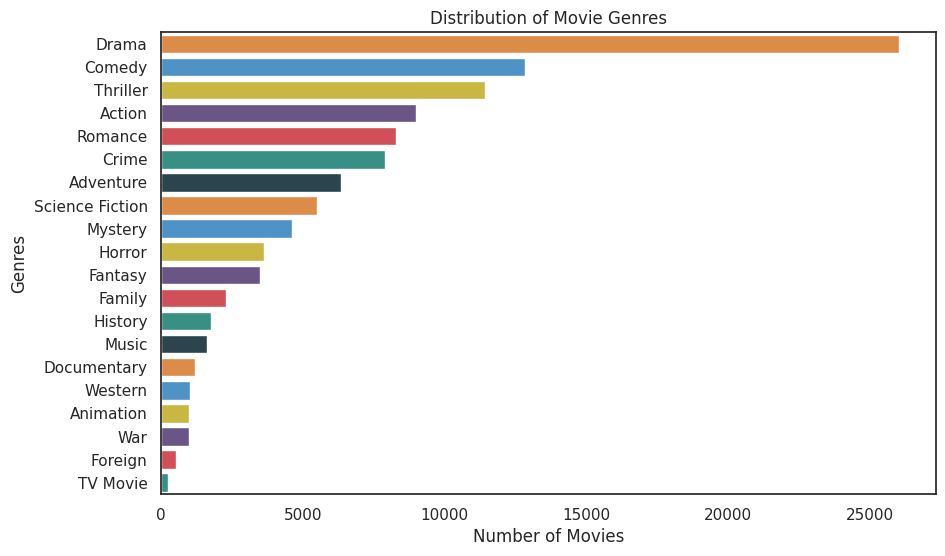

In [4]:
genre_counts = genre_dummies.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette=palette)
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.show()

## User Rating Distribution

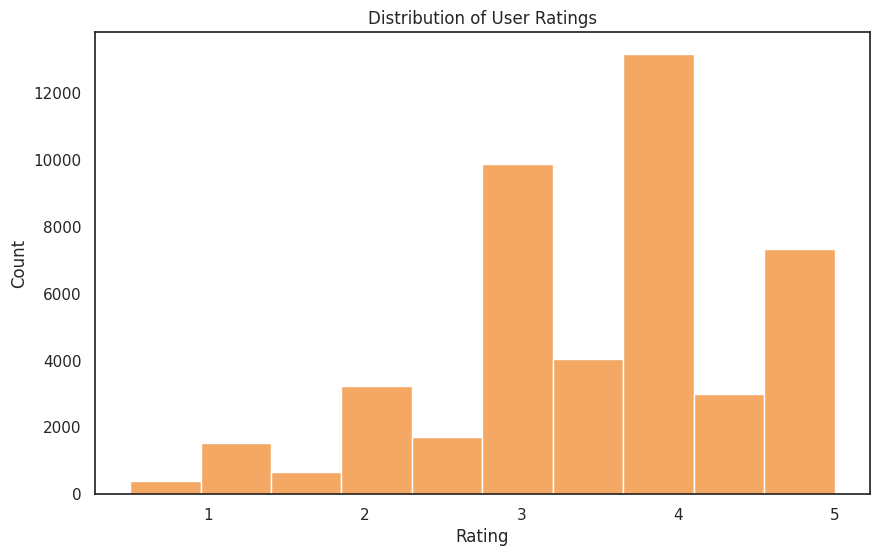

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['rating'], bins=10, kde=False, color=palette[0])
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Heatmap of Correlations Between Movie Attributes

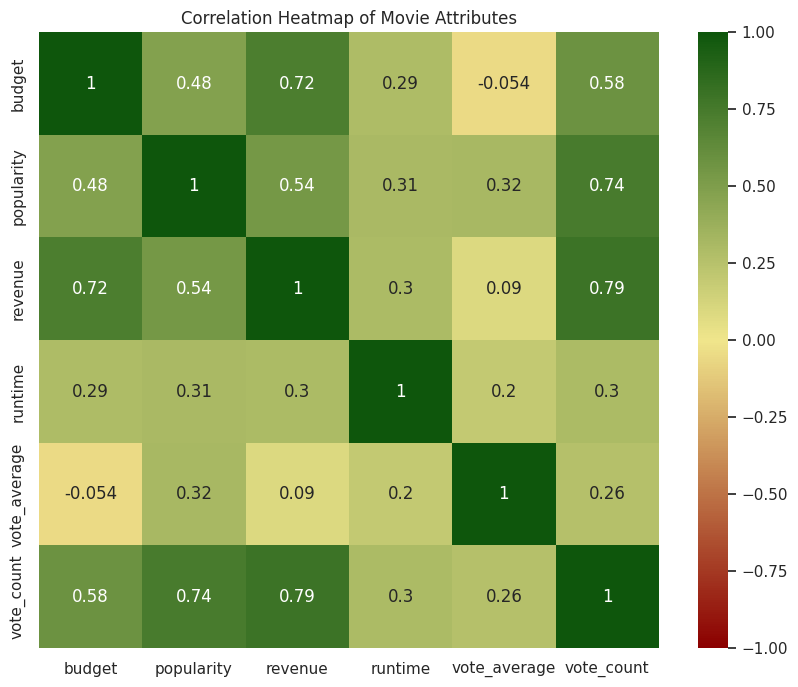

In [6]:
# Define the custom colormap
colors = ['#8B0000', '#f0e68c', '#0e560c']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

numeric_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
correlation_matrix = merged_data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Movie Attributes')
plt.show()

## User Rating Behavior (Number of Ratings vs Average Rating)

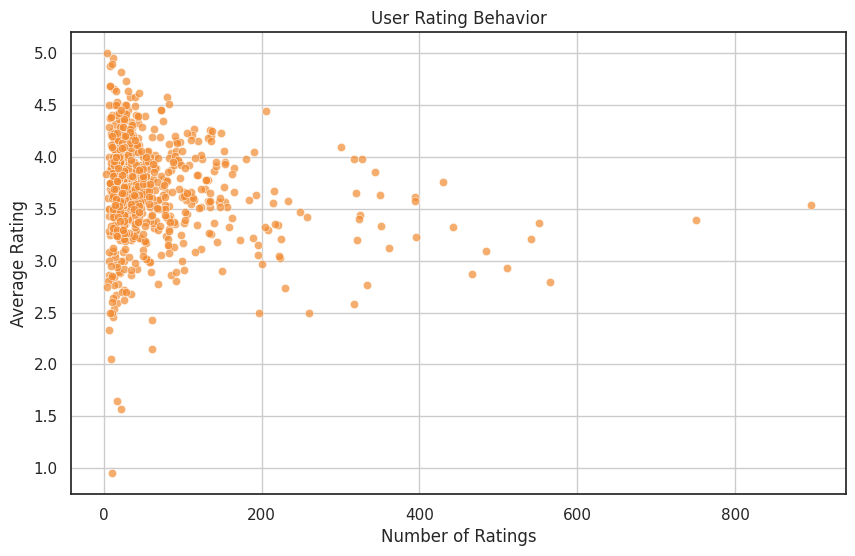

In [7]:
user_ratings = merged_data.groupby('userId')['rating'].agg(['mean', 'count'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_ratings['count'], y=user_ratings['mean'], alpha=0.7)
plt.title('User Rating Behavior')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

## Rating Distribution by Movie

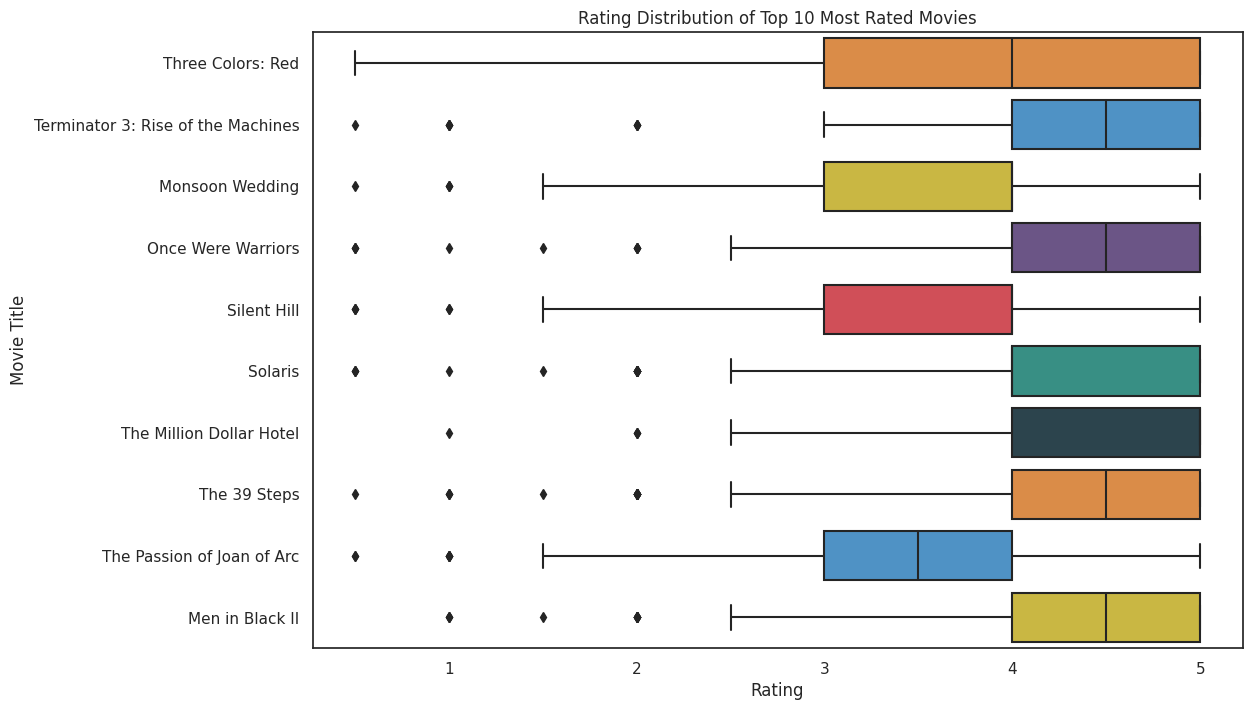

In [8]:
top_rated_movies = merged_data['title'].value_counts().index[:10]

plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='title', data=merged_data[merged_data['title'].isin(top_rated_movies)], palette=palette)
plt.title('Rating Distribution of Top 10 Most Rated Movies')
plt.xlabel('Rating')
plt.ylabel('Movie Title')
plt.show()

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 5. Prepare Data for the Model </b></div>

- **Step 10: Preprocessing for Model Input**. We will ensure that userId and movieId are properly formatted as integers. The ratings are also normalized to a scale of 0-1, which helps with model convergence during training.
- **Step 11: Splitting the Data**. The dataset is split into training and testing sets (80% for training and 20% for testing). This allows us to train the model on one portion of the data and evaluate its performance on unseen data.

In [9]:
# Convert 'userId' and 'movieId' to integers as they will be used as inputs for embedding layers
merged_data['userId'] = merged_data['userId'].astype('int')
merged_data['movieId'] = merged_data['movieId'].astype('int')

# Determine the number of unique users and movies to define the size of embedding layers
num_users = merged_data['userId'].nunique()
num_movies = merged_data['movieId'].nunique()

# Normalize the ratings to a 0-1 scale for easier model training (original scale is 1-5)
merged_data['rating'] = merged_data['rating'] / merged_data['rating'].max()

# Split the data into training and testing sets (80% train, 20% test)
train, test = train_test_split(merged_data, test_size=0.2, random_state=42)

# Prepare the input features (userId, movieId) and target (rating) for both train and test sets
train_user_ids = train['userId'].values
train_movie_ids = train['movieId'].values
train_ratings = train['rating'].values

test_user_ids = test['userId'].values
test_movie_ids = test['movieId'].values
test_ratings = test['rating'].values

# Update number of unique users and movies to ensure all values are covered (important for embedding layers)
num_users = max(train_user_ids.max(), test_user_ids.max()) + 1
num_movies = max(train_movie_ids.max(), test_movie_ids.max()) + 1

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 6. Build the Neural Network Model </b></div>

- **Step 12: Building the Recommendation Model**. We will use a neural network-based approach for this recommendation system. The key features of this model include:
    - **Embedding Layers**: Both users and movies are represented by embedding vectors. These embeddings capture latent relationships between users and movies.
    - **Concatenation**: The user and movie embeddings are concatenated and passed through dense layers to predict the user’s rating for a movie.
- **Step 13: Adding Dense Layers**. 
    - After concatenating the user and movie embeddings, let's add two dense (fully connected) layers. These layers model the interaction between users and movies.
    - Activation Functions: We will use the ReLU (Rectified Linear Unit) activation function for the hidden layers, which helps the model learn non-linear relationships.
- **Step 14: Compiling the Model**. Let's compile the model using Mean Squared Error (MSE) as the loss function, which is appropriate for a regression task like predicting ratings. The optimizer used is Adam, a popular choice for deep learning models due to its efficiency.

In [10]:
# Define input layers for user IDs and movie IDs
user_input = layers.Input(shape=(1,), name='user_input')
movie_input = layers.Input(shape=(1,), name='movie_input')

# Embedding layers for users and movies
# These embeddings learn a fixed-length representation for users and movies
user_embedding = layers.Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding = layers.Flatten()(user_embedding)

movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding = layers.Flatten()(movie_embedding)

# Concatenate the user and movie embeddings
concatenated = layers.Concatenate()([user_embedding, movie_embedding])

# Add dense layers (fully connected layers) to model interactions between user and movie features
dense_1 = layers.Dense(128, activation='relu')(concatenated)
dense_2 = layers.Dense(64, activation='relu')(dense_1)

# Output layer: predicting the rating as a single value (regression task)
output = layers.Dense(1)(dense_2)

# Build the model and compile it with Mean Squared Error (MSE) loss function for regression
model = models.Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Print a summary of the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     33,600 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │  8,035,950 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,090,799 (30.86 MB)

 Trainable params: 8,090,799 (30.86 MB)

 Non-trainable params: 0 (0.00 B)

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 7. Training and Evaluating the Model </b></div>

In [11]:
# Train the model using the training data, and validate it on the test data
history = model.fit(
    [train_user_ids, train_movie_ids],  # Input: user and movie IDs
    train_ratings,                      # Target: ratings
    epochs=5,                          
    batch_size=32,                     
    validation_data=([test_user_ids, test_movie_ids], test_ratings),  
    verbose=1                           # Show training progress
)

# Evaluate the model's performance on the test data using Mean Squared Error (MSE)
mse = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f'Test MSE: {mse}')

Epoch 1/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 0.0712 - val_loss: 0.0336
Epoch 2/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 0.0299 - val_loss: 0.0324
Epoch 3/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - loss: 0.0260 - val_loss: 0.0329
Epoch 4/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 45s 40ms/step - loss: 0.0216 - val_loss: 0.0342
Epoch 5/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - loss: 0.0175 - val_loss: 0.0357
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363
Test MSE: 0.03570808842778206


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5;overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 8. Advanced Model with Dropout </b></div>

- **Step 15 (optional): Enhancing the Model**. To enhance the model’s robustness and prevent overfitting, we will introduce dropout regularization. Dropout randomly drops units in the neural network during training, forcing the model to generalize better.

In [12]:
# Add dropout layers to prevent overfitting and help the model generalize better
user_input = layers.Input(shape=(1,), name='user_input')
movie_input = layers.Input(shape=(1,), name='movie_input')

# Embedding layers for users and movies
user_embedding = layers.Embedding(input_dim=num_users, output_dim=50)(user_input)
user_embedding = layers.Flatten()(user_embedding)

movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=50)(movie_input)
movie_embedding = layers.Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = layers.Concatenate()([user_embedding, movie_embedding])

# Add dense layers with dropout
dense_1 = layers.Dense(128, activation='relu')(concat)
dense_1 = layers.Dropout(0.2)(dense_1)  # 20% dropout for regularization

dense_2 = layers.Dense(64, activation='relu')(dense_1)
dense_2 = layers.Dropout(0.2)(dense_2)

# Output layer for rating prediction
output = layers.Dense(1)(dense_2)

# Compile the advanced model with MSE loss
model = models.Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │     33,600 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 50)     │  8,035,950 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,090,799 (30.86 MB)

 Trainable params: 8,090,799 (30.86 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the advanced model
history = model.fit(
    [train_user_ids, train_movie_ids],
    train_ratings,
    epochs=5,
    batch_size=32,
    validation_data=([test_user_ids, test_movie_ids], test_ratings),
    verbose=1
)

# Evaluate the advanced model
mse = model.evaluate([test_user_ids, test_movie_ids], test_ratings)
print(f'Test MSE: {mse}')

Epoch 1/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - loss: 0.0746 - val_loss: 0.0337
Epoch 2/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - loss: 0.0341 - val_loss: 0.0326
Epoch 3/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.0305 - val_loss: 0.0321
Epoch 4/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - loss: 0.0276 - val_loss: 0.0320
Epoch 5/5
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - loss: 0.0246 - val_loss: 0.0330
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0340
Test MSE: 0.03299201279878616


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:110%; font-family:Arial, sans-serif; background-color:#0e560c; color:#E5EFE5; overflow:hidden; box-shadow:0 4px 8px rgba(0, 0, 0, 0.3);"><b> 9. Generation of Movie Recommendations </b></div>

## 9.1. Extract User's History
We will extract all the movie IDs that a specific user has rated:

In [14]:
user_id = 3  # You can replace it with different user ID
rated_movies = merged_data[merged_data['userId'] == user_id][['movieId', 'rating', 'title']]

## 9.2. Generate Predictions for All Unseen Movies
Now, predict the ratings for all movies that the user has not rated yet:

In [15]:
# Get all unique movie IDs
all_movie_ids = merged_data['movieId'].unique()

# Find movies the user hasn't rated
unseen_movie_ids = np.setdiff1d(all_movie_ids, rated_movies['movieId'])

# Create arrays for unseen movie IDs and corresponding user ID
unseen_movie_ids_input = np.array(unseen_movie_ids)
user_input_array = np.full(len(unseen_movie_ids_input), user_id)

# Predict ratings for unseen movies
predicted_ratings = model.predict([user_input_array, unseen_movie_ids_input])

# Combine unseen movie IDs with predicted ratings
movie_predictions = pd.DataFrame({
    'movieId': unseen_movie_ids_input,
    'predicted_rating': predicted_ratings.flatten()
})

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## 9.3. Sort by Predicted Ratings
Once we have the predicted ratings, we'll sort them to get the top-rated movies:

In [16]:
# Sort by predicted rating in descending order and take the top recommendations
top_movie_recommendations = movie_predictions.sort_values(by='predicted_rating', ascending=False).head(10)

# Merge the recommendations with movie titles for easier readability
top_movie_recommendations = pd.merge(top_movie_recommendations, movies[['id', 'title']], left_on='movieId', right_on='id')

print("Movies the user has already rated:")
print(rated_movies)

print("\nTop recommended movies:")
print(top_movie_recommendations[['title', 'predicted_rating']])

Movies the user has already rated:
    movieId  rating                                 title
64      110     0.8                     Three Colors: Red
65      247     0.7                           The Killing
66      267     0.6                            Live Flesh
67      296     0.9    Terminator 3: Rise of the Machines
68      318     1.0              The Million Dollar Hotel
69      377     0.5             A Nightmare on Elm Street
70      527     0.6                    Once Were Warriors
71      588     0.6                           Silent Hill
72      592     0.6                      The Conversation
73      593     0.6                               Solaris
74      595     0.4                 To Kill a Mockingbird
75      778     0.8             Monsieur  Hulot's Holiday
76      866     0.6                     Finding Neverland
77     1271     0.6                                   300
78     1378     0.8                              Shortbus
79     1580     0.7                  